# Content Analysis with Sitemaps and Python

Where would you start if you wanted to get an understanding of a website's content, especially large publishers? I'm usually interested in the following questions: 

- How often and how much do they publish?
- Are there daily, weekly, monthly, or annual trends in their publishing activity?
- What topics to they write about or what products do they sell? 
- What are the trends in their topics? Which topics are gaining in volume and which are not? 
- How is the content or product split across languages, regions, categories, or authors?

In their most basic form, sitemaps are required to only have the "loc" tag (under the parent "url" tag). Essentially, a sitemap is allowed to simply be list of URLs. Other optional tags are allowed, most importantly "lastmod", as well as "changefreq",  "priority", and in some cases "alternate". 
If you have "lastmod" in the sitemap (and most reputable sites do), then you can get all the information related to publishing activity and trends. Then the richness of URLs determines how much information you can extract (if the URLs are structured with no real information like www.example.com/product/12345 then you won't be able to get much from the sitemap).  
The goal of this tutorial is to make sitemaps less boring objects!  

I'll be analyzing the sitemaps of BuzzFeed, and since they have "lastmod" as well as consistent and rich URLs, we will be able to answer all of the questions raised above.  

I'll be using Python for the analysis and an interactive version of the article is available here. I encourage you to check it out if you want to follow along. This way you can make changes and explore other things that you might be curious about. The data visualizations are also interactive, so you will be able to zoom, hover, and explore a little better.  
If you don't know any programming, you can safely ignore all the code snippets (which I will be explaining anyways). 

To get the sitemaps in a table format, I'll use the `sitemap_to_df` function from the advertools package. "df" is short for DataFrame, which is basically a data table. You simply pass the URL of a sitemap (or a sitemap index URL) to the function, and it returns the sitemap(s) in tabular format. If you give it a sitemap index, then it will go through all the sub-sitemaps and extract the URLs and whatever other data is available.  
In addition to advertools, I'll be using pandas for data manipulation, as well as plotly for data visualization.

In [2]:
import advertools as adv
import plotly.graph_objects as go
import pandas as pd

# buzzfeed_generic = adv.sitemap_to_df('https://www.buzzfeed.com/sitemap/buzzfeed.xml')
# buzzfeed_tasty = adv.sitemap_to_df('https://www.buzzfeed.com/sitemap/tasty.xml')
# buzzfeed_video = adv.sitemap_to_df('https://www.buzzfeed.com/sitemap/video.xml')
# buzzfeed_shopping = adv.sitemap_to_df('https://www.buzzfeed.com/sitemap/shopping.xml')
# buzzfeed = pd.concat([buzzfeed_generic, buzzfeed_tasty, buzzfeed_video, buzzfeed_shopping],
#                      ignore_index=True)

Since I have saved them to CSV files so you don't have to re-import them, we'll open the files directly, and put them in one big DataFrame. We will set the "lastmod" column to become the index and set its type as "datetime" so we can access special date and time functionality.

In [3]:
import os

In [4]:
buzzfeed = pd.concat((pd.read_csv('data/' + file) for file in os.listdir('data/')), 
                     ignore_index=True)
buzzfeed['lastmod'] = pd.to_datetime(buzzfeed['lastmod'])
buzzfeed = buzzfeed.set_index('lastmod')
buzzfeed = buzzfeed.drop(columns=['video'])
buzzfeed

,loc,sitemap
lastmod,,
NaT,https://www.buzzfeed.com/watch/video/1961,https://www.buzzfeed.com/sitemap/video/2016_28...
NaT,https://www.buzzfeed.com/watch/video/1503,https://www.buzzfeed.com/sitemap/video/2016_28...
NaT,https://www.buzzfeed.com/watch/video/1741,https://www.buzzfeed.com/sitemap/video/2016_28...
NaT,https://www.buzzfeed.com/watch/video/108,https://www.buzzfeed.com/sitemap/video/2016_28...
NaT,https://www.buzzfeed.com/watch/video/1975,https://www.buzzfeed.com/sitemap/video/2016_28...
...,...,...
2020-03-31 00:00:00+00:00,https://www.buzzfeed.com/jp/sonomishimada/chin...,https://www.buzzfeed.com/sitemap/tasty/2020_13...
2020-03-27 00:00:00+00:00,https://www.buzzfeed.com/br/agathadahora/recei...,https://www.buzzfeed.com/sitemap/tasty/2020_13...
2020-03-28 00:00:00+00:00,https://www.buzzfeed.com/jp/redkikuchi/potato-...,https://www.buzzfeed.com/sitemap/tasty/2020_13...


The above is how the DataFrame looks like. "lastmod" is the index, and we have two columns; "loc" which is the URLs, and "sitemap", which is the URL of the siteamp from which the URL was retreived.   
`NaT` stands for "not-a-time", which is the missing value representation of `datetime` objects.  
As you can see, we have around half a million URLs to go through. 

## Sitemap Categories
If you look at the URLs of the sitemaps, you will see that they contain the website category, for example:

`https://www.buzzfeed.com/sitemap/buzzfeed/2019_5.xml`  
`https://www.buzzfeed.com/sitemap/shopping/2018_13.xml`

This can be helpful in understanding which category the URL falls under. 
To extract the category from those URLs, the following line splits the XML URLs by the forward slash character, and takes the fifth element (index 4) of the resulting list. The extracted text will be assigned to a new column called `sitemap_cat`.

In [5]:
buzzfeed['sitemap_cat'] = buzzfeed['sitemap'].str.split('/').str[4]
buzzfeed.sample(5)

,loc,sitemap,sitemap_cat
lastmod,,,
2020-02-27 00:00:00+00:00,https://www.buzzfeed.com/br/hanifahrahman/test...,https://www.buzzfeed.com/sitemap/buzzfeed/2020...,buzzfeed
2011-05-27 00:00:00+00:00,https://www.buzzfeed.com/pharmacy/buy-cheap-di...,https://www.buzzfeed.com/sitemap/buzzfeed/2011...,buzzfeed
2017-11-06 00:00:00+00:00,https://www.buzzfeed.com/elliewoodward/things-...,https://www.buzzfeed.com/sitemap/buzzfeed/2017...,buzzfeed
2013-04-15 00:00:00+00:00,https://www.buzzfeed.com/ktlincoln/the-dude-wh...,https://www.buzzfeed.com/sitemap/buzzfeed/2013...,buzzfeed
2012-10-24 00:00:00+00:00,https://www.buzzfeed.com/hollywoodreporter/oba...,https://www.buzzfeed.com/sitemap/buzzfeed/2012...,buzzfeed


Now that we have a column showing the categories, we can count how many URLs they have and get an overview of the relative volume of content under each. The following code simply counts the values in that column and formats the resulting DataFrame. 

In [6]:
(buzzfeed['sitemap_cat']
 .value_counts()
 .to_frame()
 .assign(percentage=lambda df: df['sitemap_cat'].div(df['sitemap_cat'].sum()))
 .style.format(dict(sitemap_cat='{:,}', percentage='{:.1%}')))

,sitemap_cat,percentage
buzzfeed,"478,430",93.4%
shopping,"13,774",2.7%
video,"10,657",2.1%
tasty,"5,337",1.0%
asis,"4,122",0.8%


It's clear the "buzzfeed" is the major category, which is basically the main site, and the others are very small in comparison.

Before proceeding further, it's important to get a better understanding of the `NaT` values that we saw at the beginning. Let's see what category they fall under.

In [7]:
buzzfeed[buzzfeed.index.isna()]['sitemap_cat'].head()

lastmod
NaT    video
NaT    video
NaT    video
NaT    video
NaT    video
Name: sitemap_cat, dtype: object

The first five fall under "video", but is that true for all the missing values?  
The following line takes a subset of the DataFrame `buzzfeed` (the subset where the index contains missing values), then takes the `sitemap_cat` column, and counts the number of unique values. Since we saw that some values are "video", if the number of unique values is one, then all categories of missing dates fall under "video".

In [8]:
buzzfeed[buzzfeed.index.isna()]['sitemap_cat'].nunique()

1

We have now uncovered a limitation in our dataset, which we know affects 2.1% of the URLs. We will not be able to analyze date-related issues with the video URLs. Nor will we be able to get any information about the content of those URLs for that matter:

In [9]:
buzzfeed[buzzfeed['sitemap_cat']=='video']['loc'].sample(10)

lastmod
NaT    https://www.buzzfeed.com/watch/video/10529
NaT    https://www.buzzfeed.com/watch/video/85114
NaT    https://www.buzzfeed.com/watch/video/67170
NaT    https://www.buzzfeed.com/watch/video/74707
NaT    https://www.buzzfeed.com/watch/video/79976
NaT    https://www.buzzfeed.com/watch/video/44036
NaT    https://www.buzzfeed.com/watch/video/58695
NaT    https://www.buzzfeed.com/watch/video/21355
NaT     https://www.buzzfeed.com/watch/video/6738
NaT    https://www.buzzfeed.com/watch/video/68506
Name: loc, dtype: object

## Publishing Trends
Let's check how many articles they publish per year, and whether or not there were higher/lower years.  
The following code `resample`s the DataFrame by "A" (for annual), and counts the rows.

In [10]:
articles_per_year = buzzfeed.resample('A')['loc'].count()
articles_per_year.to_frame()

,loc
lastmod,
2008-12-31 00:00:00+00:00,2646
2009-12-31 00:00:00+00:00,3514
2010-12-31 00:00:00+00:00,11994
2011-12-31 00:00:00+00:00,46974
2012-12-31 00:00:00+00:00,62006
2013-12-31 00:00:00+00:00,61941
2014-12-31 00:00:00+00:00,62563
2015-12-31 00:00:00+00:00,56018
2016-12-31 00:00:00+00:00,49835


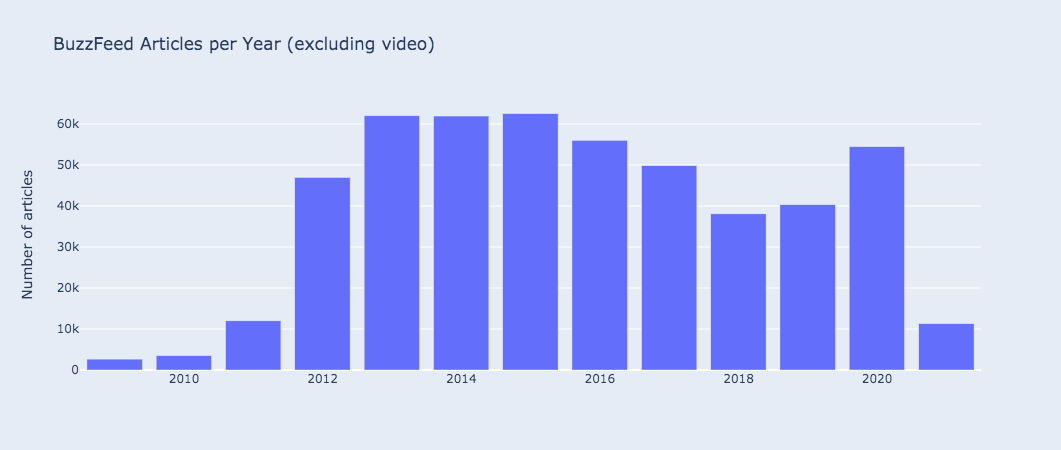

In [11]:
fig = go.Figure()
fig.add_bar(x=articles_per_year.index, y=articles_per_year.values)
fig.layout.title = 'BuzzFeed Articles per Year (excluding video)'
fig.layout.yaxis.title = 'Number of articles'
fig.layout.paper_bgcolor = '#E5ECF6'
fig.show(config=dict(displayModeBar=False))

We can see dramatic increases in articles from 2010 (3,514) to 2011 (12k), and from 2011 to 2012 (46k). It's extremely unlikely that a website can increase it's publishing activity almost fourfold, twice, and in two consecutive years. They might have made some acquisitions, content partnerships, or maybe there are issues with the dataset. When we check the authors later, we will see a possible answer to this sudden increase. 
Let's zoom in further. Let's do the same, but look at the monthly trend.

In [12]:
articles_per_month = buzzfeed.resample('M')['loc'].count()
articles_per_month.to_frame()

,loc
lastmod,
2008-01-31 00:00:00+00:00,163
2008-02-29 00:00:00+00:00,159
2008-03-31 00:00:00+00:00,158
2008-04-30 00:00:00+00:00,170
2008-05-31 00:00:00+00:00,216
...,...
2019-12-31 00:00:00+00:00,4245
2020-01-31 00:00:00+00:00,3562
2020-02-29 00:00:00+00:00,3483


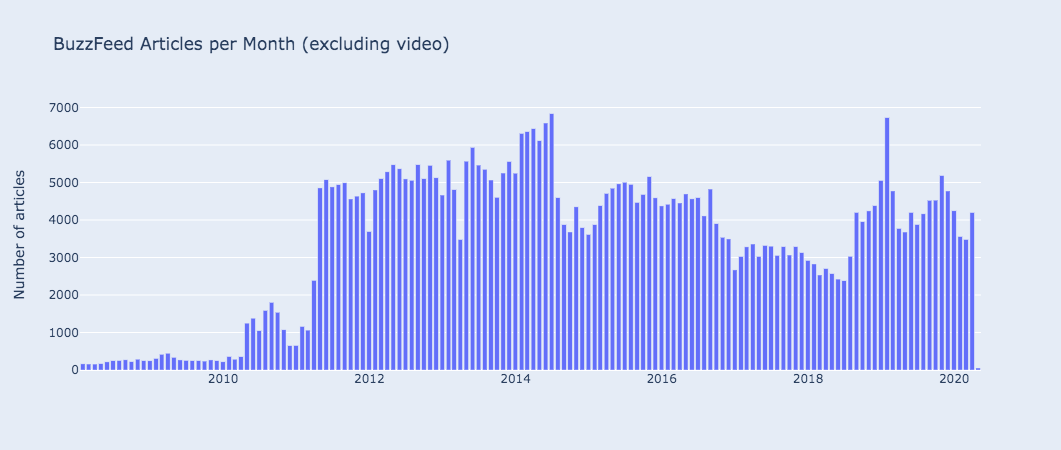

In [13]:
fig = go.Figure()
fig.add_bar(x=articles_per_month.index, y=articles_per_month.values)
fig.layout.title = 'BuzzFeed Articles per Month (excluding video)'
fig.layout.yaxis.title = 'Number of articles'
fig.layout.paper_bgcolor = '#E5ECF6'
fig.show(config=dict(displayModeBar=False))

This confirms the trend above and shows a more sudden change. In April 2010, they published 1,249 articles, after having published 354 the previous month. We have something similar happening in April of 2011. Now it is almost certain that this is not an organic natural growth in their publishing activity.  
We can also take a look at the trend by day of the week. 

In [36]:
(buzzfeed
 .groupby(buzzfeed.index.weekday)['loc']
 .count().to_frame()
 .rename(columns=dict(loc='count'))
 .assign(day=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
 .style.bar(color='lightblue').format(dict(count='{:,}'))
)

,count,day
lastmod,,
0.0,"82,469",Mon
1.0,"86,661",Tue
2.0,"85,311",Wed
3.0,"82,199",Thu
4.0,"81,362",Fri
5.0,"43,487",Sat
6.0,"40,174",Sun


Nothing very surprising here. They produce a fairly consistent number of articles on weekdays, which is almost double what they produce on weekends. 

## Categories' Trends

We can also take a look at the annual trends by category and see if something pops out.  
The following code goes through all categories, and creates a plot for the number of articles per year. 

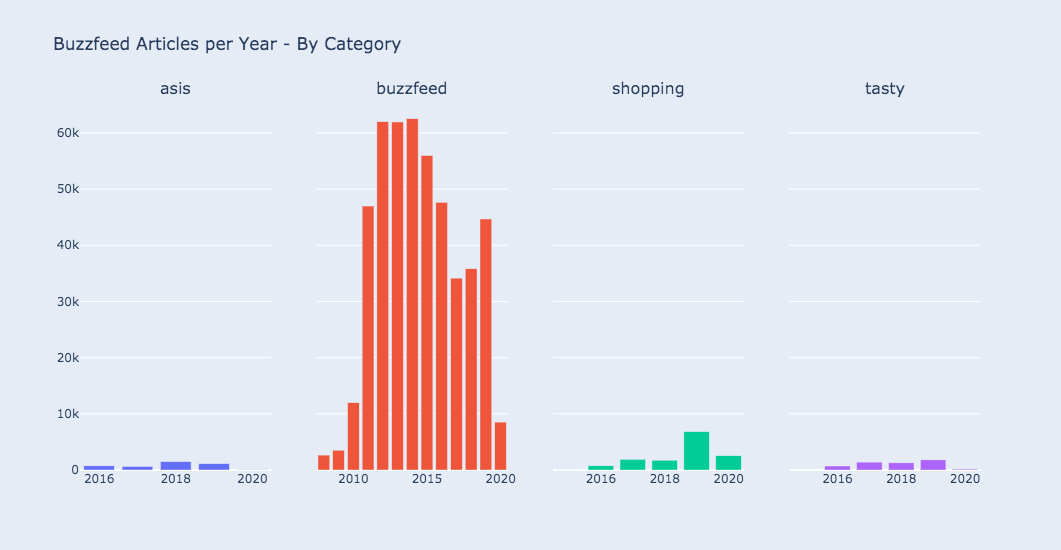

In [15]:
from plotly.subplots import make_subplots
categories = buzzfeed['sitemap_cat'].unique()
fig = make_subplots(rows=1, cols=len(categories)-1, subplot_titles=categories[1:],
                    shared_yaxes=True)
for i, cat in enumerate(categories[1:]):
    if cat == 'video':
        continue
    df = buzzfeed[buzzfeed['sitemap_cat']==cat].resample('A')['loc'].count()
    fig.add_bar(x=df.index.year, y=df.values, row=1, col=i+1, showlegend=False, name=cat)
fig.layout.height = 550
fig.layout.paper_bgcolor = '#E5ECF6'
fig.layout.title = 'Buzzfeed Articles per Year - By Category'
fig.show(config=dict(displayModeBar=False))

I can see two things here. First is the jump in "shopping" articles from 1,732 to 6,845 in 2019, and 2020 is on track to top that. It seems that it is working well for them. Checking some of those articles you can see that they are running affiliate programs and promoting some products. Second, is how misleading this chart can be. For example Tasty has been acquired by BuzzFeed, and here you can see it occupying a tiny portion of the content. But if you check their [Facebook page](https://www.facebook.com/buzzfeedtasty/) you'll see that they have almost one hundred million followers. So keep this in mind, be skeptical, and try to verify the information from other sources where possible. 

## URL Structure
We can now move to analyze whatever information we can get from the URLs, and here is a random sample:

In [61]:
buzzfeed['loc'].sample(15).tolist()

['https://www.buzzfeed.com/jp/hanasasaki/seven-eleven-onigiri-soboro',
 'https://www.buzzfeed.com/ehisosifo1/emo-pop-punk-bands-reimagined-john-mulaney-quotes',
 'https://www.buzzfeed.com/wwtdd/kendall-jenner-offered-millions-for-adult-webcam-w-quz',
 'https://www.buzzfeed.com/br/manuelabarem/coisas-que-uma-mulher-pensa-ao-usar-o-tinder',
 'https://www.buzzfeed.com/elle/holiday-party-outfits-party-dresses-blazers-jump-p3i',
 'https://www.buzzfeed.com/mikespohr/eight-of-these-people-are-grown-up-child-stars-can-you-pick',
 'https://www.buzzfeed.com/mjs538/if-trump-is-not-elected-then',
 'https://www.buzzfeed.com/starpulse/swedish-fans-slam-rihanna-over-her-disgusting-rsh',
 'https://www.buzzfeed.com/erinlarosa/cafe-con-leche-forever-and-ever',
 'https://www.buzzfeed.com/daves4/mom-questions',
 'https://www.buzzfeed.com/fr/keelyflaherty/realiste-pas-pessimiste',
 'https://www.buzzfeed.com/de/karstenschmehl/13-beruhmte-mittelfinger-die-geschichte-geschrieben-haben',
 'https://www.buzzfeed

The general template seems to be in the form `buzzfeed.com/{language}/{author}/{article-title}`  and the English articles don't have "/en/" in them.  
Let's now create a new column for languages, which can be done by extracting the pattern of two letters between two slashes. If nothing is available, it will be filled with "en". Now we can see the number of articles per language. 

In [17]:
buzzfeed['lang'] = buzzfeed['loc'].str.extract('/([a-z]{2})/')[0].fillna('en')
by_lang = buzzfeed['lang'].value_counts()
by_lang.to_frame().style.format('{:,}')

,lang
en,"441,283"
br,"21,104"
jp,"16,226"
mx,"12,714"
de,"10,942"
fr,"10,051"


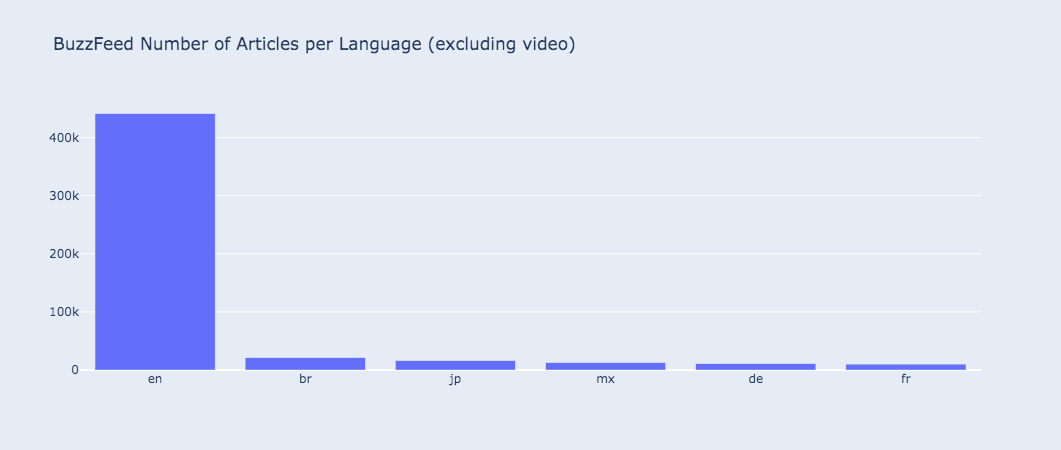

In [18]:
fig = go.Figure()
fig.add_bar(x=by_lang.index, y=by_lang.values)
fig.layout.title = 'BuzzFeed Number of Articles per Language (excluding video)'
fig.layout.paper_bgcolor = '#E5ECF6'
fig

We can also see the monthly number of articles per language for a better view.

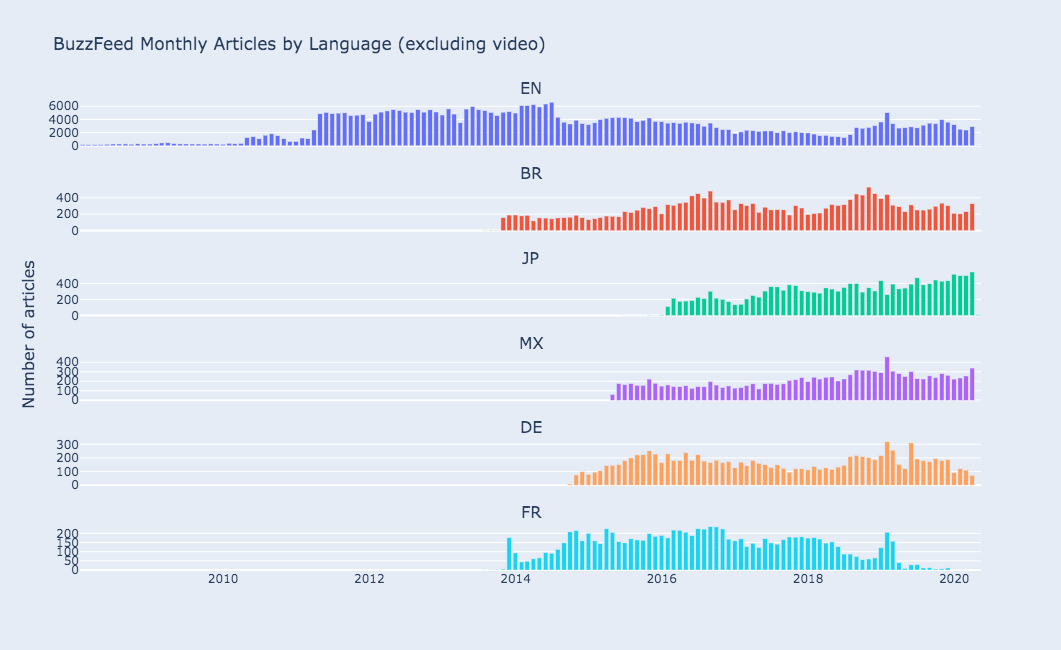

In [19]:
fig = make_subplots(cols=1, rows=len(by_lang), subplot_titles=by_lang.index.str.upper(),
                    shared_xaxes=True, y_title='Number of articles')
for i, lang in enumerate(by_lang):
    df = buzzfeed[buzzfeed['lang']==by_lang.index[i]].resample('M')['loc'].count()
    fig.add_bar(x=df.index, y=df.values, row=i+1, col=1, showlegend=False, name=lang)
fig.layout.height = 650
fig.layout.title = 'BuzzFeed Monthly Articles by Language (excluding video)'
fig.layout.paper_bgcolor = '#E5ECF6'
fig.show(config=dict(displayModeBar=False))

## Authors
Now let's do the same for authors. It's the same process, we split the "loc" column by "/" and extract the second to last element, and place it in a new "author" column. After that we can count the articles by author.

In [20]:
buzzfeed['author'] = buzzfeed['loc'].str.split('/').str[-2]
buzzfeed.sample(10)

,loc,sitemap,sitemap_cat,lang,author
lastmod,,,,,
2015-11-05 00:00:00+00:00,https://www.buzzfeed.com/danielacadena/cosas-q...,https://www.buzzfeed.com/sitemap/buzzfeed/2015...,buzzfeed,en,danielacadena
2019-11-18 00:00:00+00:00,https://www.buzzfeed.com/christinalan/hack-eve...,https://www.buzzfeed.com/sitemap/buzzfeed/2016...,buzzfeed,en,christinalan
2014-03-18 00:00:00+00:00,https://www.buzzfeed.com/ashleyperez/colordao-...,https://www.buzzfeed.com/sitemap/buzzfeed/2014...,buzzfeed,en,ashleyperez
2016-05-08 00:00:00+00:00,https://www.buzzfeed.com/ciaraallen/can-you-pa...,https://www.buzzfeed.com/sitemap/buzzfeed/2016...,buzzfeed,en,ciaraallen
2014-03-07 00:00:00+00:00,https://www.buzzfeed.com/thesuperficial/the-cr...,https://www.buzzfeed.com/sitemap/buzzfeed/2014...,buzzfeed,en,thesuperficial
2015-11-30 00:00:00+00:00,https://www.buzzfeed.com/alannabennett/sweet-c...,https://www.buzzfeed.com/sitemap/buzzfeed/2015...,buzzfeed,en,alannabennett
2016-01-25 00:00:00+00:00,https://www.buzzfeed.com/anjalipatel/for-the-l...,https://www.buzzfeed.com/sitemap/buzzfeed/2016...,buzzfeed,en,anjalipatel
2017-09-07 00:00:00+00:00,https://www.buzzfeed.com/audreyworboys/gimme-s...,https://www.buzzfeed.com/sitemap/buzzfeed/2017...,buzzfeed,en,audreyworboys
2019-12-30 00:00:00+00:00,https://www.buzzfeed.com/mx/evelinamedina/eres...,https://www.buzzfeed.com/sitemap/buzzfeed/2019...,buzzfeed,mx,evelinamedina


In [40]:
print('Number of authors:', buzzfeed['author'].nunique(), '\n')
(buzzfeed['author']
 .value_counts()
 .to_frame()
 .assign(perc=lambda df: df['author'].div(df['author'].sum()),
         cum_perc=lambda df: df['perc'].cumsum())[:20]
 .reset_index()
 .rename(columns=dict(index='author', author='count', perc='%', cum_perc='cum. %'))
 .style.set_caption('Top Authors by Number of Articles')
 .format({'count': '{:,}', '%': '{:.1%}', 'cum. %': '{:.1%}'})
 .background_gradient(cmap='cividis'))

Number of authors: 6834 



,author,count,%,cum. %
0,fabordrabfeed,"11,999",2.3%,2.3%
1,huffpost,"11,064",2.2%,4.5%
2,video,"10,657",2.1%,6.6%
3,hollywoodreporter,"8,492",1.7%,8.2%
4,soft,"5,636",1.1%,9.3%
5,whitneyjefferson,"5,405",1.1%,10.4%
6,flavorwire,"5,334",1.0%,11.4%
7,mjs538,"5,253",1.0%,12.5%
8,lyapalater,"5,218",1.0%,13.5%
9,justjared,"4,965",1.0%,14.4%


"cum. %" shows the cumulative percentage of the number of articles by the authors up to the current row. The first three authors generated 6.6% of the total articles for example. You can also see that the first few are actually other news organizations, and not people. I manually checked a few articles by "huffpost", and got a 404 error.  
The following code snippet goes through a random sample of URLs where the author is "huffpost", and prints the URL along with the response.

In [38]:
import requests
for url in buzzfeed[buzzfeed['author']=='huffpost']['loc'].sample(10).tolist():    
    resp = requests.get(url)
    print(url,'|', resp.status_code, resp.reason)


https://www.buzzfeed.com/huffpost/st-louis-shooting-4-dead-after-shots-fired-insid-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/rush-limbaugh-on-sandra-fluke-obama-call-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/micaela-schaefer-shows-sideboob-in-vhs-tape-dress-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/kendall-and-kylie-jenner-start-blog-photos-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/stephanie-seymour-calls-cops-on-peter-brant-jr-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/rachel-maddow-mocks-mitt-romneys-interview-bl-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/james-holmes-planned-colorado-shooting-for-months-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/zach-galifianakis-to-take-elizabeth-mimi-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/oscar-nominations-2012-academy-award-nominees-lis-7p0 | 404 Not Found
https://www.buzzfeed.com/huffpost/dolce-gabbana-black-figurine-earrings-and-dr-7p0 | 404 Not Foun

And this is another issue in the dataset. The articles of the top contributors don't exist anymore. I didn't check them all, and the proper way is to go through all of the half-a-million URLs to quantify this issue.  
The existence of such a large number of articles by large news organizations might be the answer to the question of the sudden increase in the volume of content on BuzzFeed. It's definitely a problem to have 404's in your sitemap, but in our case it is great that they didn't remove them, because we have a better view on the history of the site, even though many URLs don't exist anymore. This also means that there might be other non-existent URLs that were removed and we don't know about. 

With such a large website, you can expect some issues especially going back seven or eight years were many things change, and many things are not relevant anymore. So let's do the same exercise for a recent period, the years 2019 and 2020 (first quarter). 

In [42]:
print('Number of authors:', format(buzzfeed[buzzfeed.index.year > 2018]['author'].nunique(), ','))
print('Number of articles:', format(buzzfeed[buzzfeed.index.year > 2018].__len__(), ','), '\n')
(buzzfeed[buzzfeed.index.year > 2018]['author']
 .value_counts()
 .to_frame()
 .assign(perc=lambda df: df['author'].div(df['author'].sum()),
         cum_perc=lambda df: df['perc'].cumsum())
 .reset_index()[:20]
 .rename(columns=dict(index='author', author='count', perc='%', cum_perc='cum. %'))
 .style.set_caption('Top Authors by Number of Articles 2019-2020')
 .format({'count': '{:,}', '%': '{:.1%}', 'cum. %': '{:.1%}'})
 .background_gradient(cmap='cividis'))

Number of authors: 1,582
Number of articles: 65,770 



,author,count,%,cum. %
0,ryanschocket2,914,1.4%,1.4%
1,daves4,831,1.3%,2.7%
2,noradominick,792,1.2%,3.9%
3,ehisosifo1,784,1.2%,5.0%
4,sydrobinson1,745,1.1%,6.2%
5,mjs538,727,1.1%,7.3%
6,sarahaspler,709,1.1%,8.4%
7,mikespohr,697,1.1%,9.4%
8,briangalindo,696,1.1%,10.5%
9,mireyagonzalez,695,1.1%,11.5%


Now all the top authors seem to be people and not organizations. We can also see that the top twenty produced 21.5% of the content in this period. And we can see how many articles each author produced, as well as the percentage of that number out of the total articles for the period.  
In case you were wondering how many articles per month each author produced: 

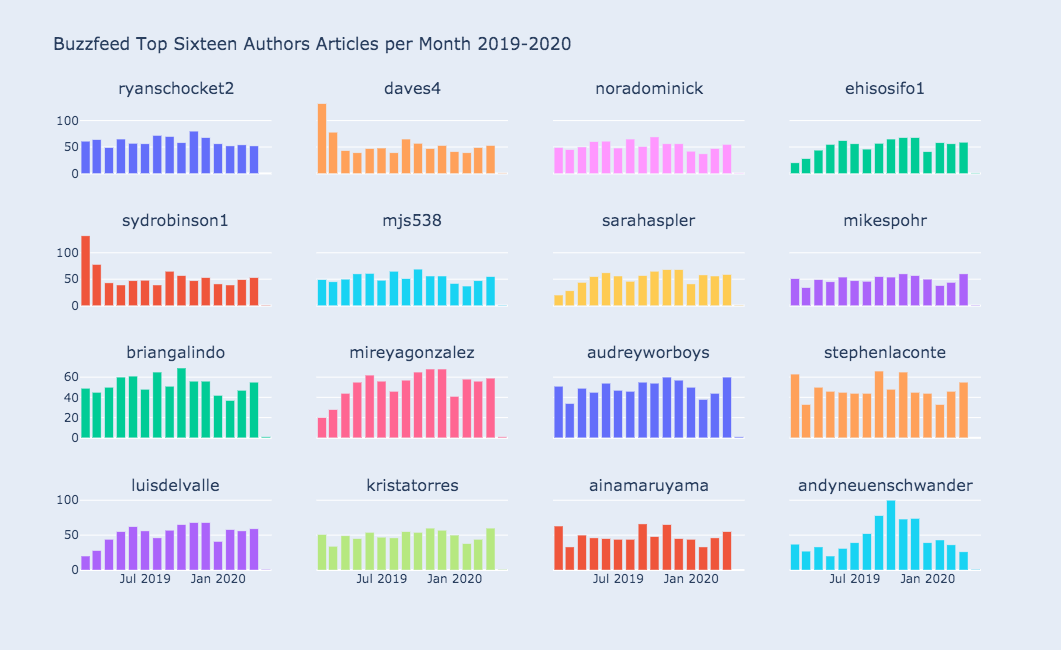

In [43]:
top16authors = buzzfeed[buzzfeed.index.year > 2018]['author'].value_counts()[:16]
df = buzzfeed[buzzfeed.index.year > 2018]
fig = make_subplots(cols=4, rows=4, subplot_titles=top16authors.index, shared_xaxes=True, shared_yaxes=True)
count = 1
for i in range(4):
    for j in range(4):
        temp_df = df[df['author']==top16authors.index[i+j]].resample('M')['loc'].count()
        fig.add_bar(x=temp_df.index, y=temp_df.values, col=i+1, row=j+1,
                    name=top16authors.index[i+j], showlegend=False)

fig.layout.paper_bgcolor = '#E5ECF6'
fig.layout.height = 650
fig.layout.title = 'Buzzfeed Top Sixteen Authors Articles per Month 2019-2020'
fig

The above was an exploratory approach, where we didn't know anything about the authors. Now that we know a little, we can use a top-down approach. The following function takes an arbitrary number of author names, and plots the monthly number of articles for them, so you can compare any two or more authors. So let's start with the top news organizations. 

In [44]:
def compare_authors(*authors):
    fig = go.Figure()
    for author in authors:
        df = buzzfeed[buzzfeed['author']==author].resample('M')['loc'].count()
        fig.add_scatter(x=df.index, y=df.values, name=author, mode='markers+lines')
    fig.layout.title = 'Articles per Month by: '  + ', '.join(authors)
    fig.layout.legend = dict(orientation='h')
    fig.layout.paper_bgcolor = '#E5ECF6'
    return fig

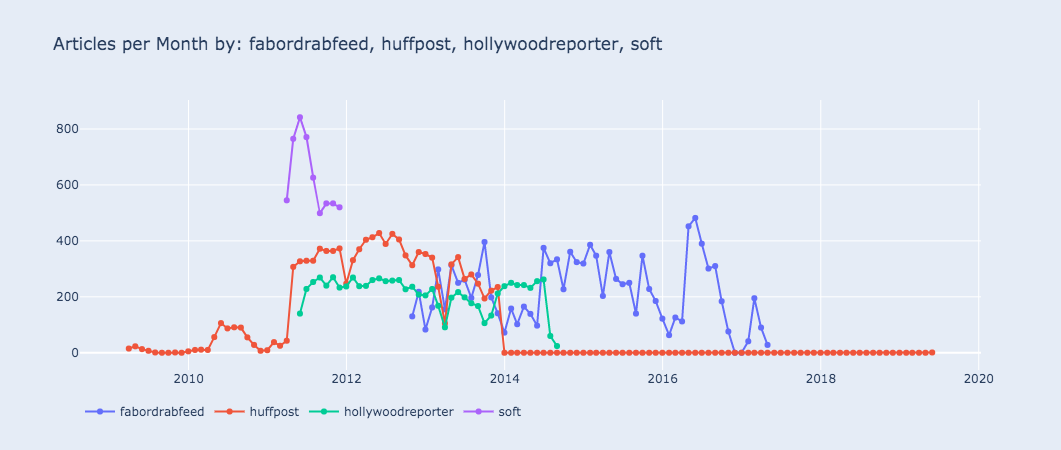

In [45]:
compare_authors('fabordrabfeed', 'huffpost', 'hollywoodreporter', 'soft')

Now it's getting more likely that the jump in articles in April 2011 was due to content partnerships, we can also see that the partnership with HuffingtonPost was ended on November of 2013, according to the sitemap at least.  
Below are the trends for the top three authors in the last five quarters. 

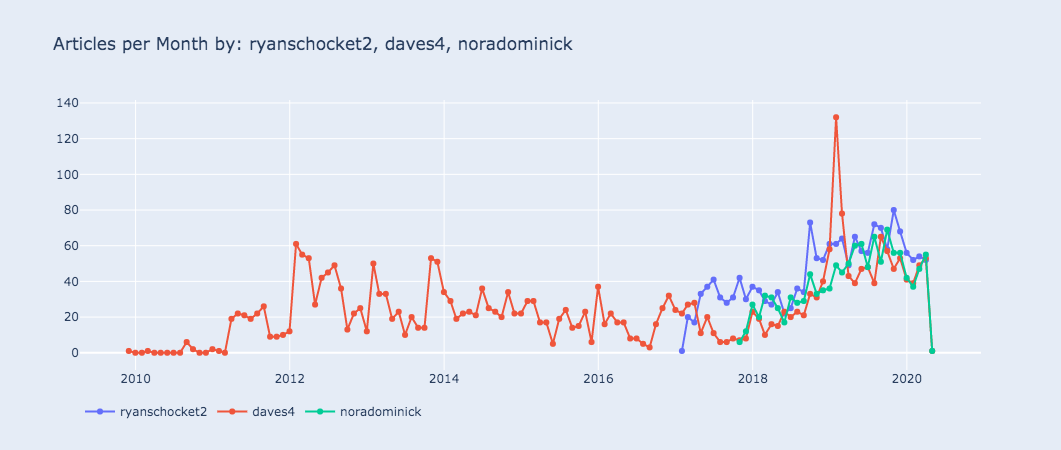

In [46]:
compare_authors('ryanschocket2', 'daves4', 'noradominick')

## Content Analysis
We now get to the final part of the URL, the slug that contains the titles of the articles. Everything up to this point was basically creating meta data by categorizing the content by date, category, language, and author. The slugs can also be extracted into their own column using the same approach. I also replaced the dashes with spaces to more easily split and analyze. 

In [47]:
buzzfeed['slugs'] =  buzzfeed['loc'].str.split('/').str[-1].str.replace('-', ' ')
buzzfeed.sample(7)

,loc,sitemap,sitemap_cat,lang,author,slugs
lastmod,,,,,,
2012-09-23 00:00:00+00:00,https://www.buzzfeed.com/mailonline/kate-middl...,https://www.buzzfeed.com/sitemap/buzzfeed/2012...,buzzfeed,en,mailonline,kate middleton photo scandal closer magazine f...
2019-05-02 00:00:00+00:00,https://www.buzzfeed.com/de/philippjahner/marv...,https://www.buzzfeed.com/sitemap/buzzfeed/2019...,buzzfeed,de,philippjahner,marvel fakten
2019-09-27 00:00:00+00:00,https://www.buzzfeed.com/brittaneytrent/footba...,https://www.buzzfeed.com/sitemap/shopping/2018...,shopping,en,brittaneytrent,football tailgate products
2011-04-02 00:00:00+00:00,https://www.buzzfeed.com/hollywoodlife/ian-som...,https://www.buzzfeed.com/sitemap/buzzfeed/2011...,buzzfeed,en,hollywoodlife,ian somerhalder explains why damon elena mak u0l
2014-12-18 00:00:00+00:00,https://www.buzzfeed.com/alexalvarez/a-shockin...,https://www.buzzfeed.com/sitemap/buzzfeed/2014...,buzzfeed,en,alexalvarez,a shocking amount of peen
2017-05-22 00:00:00+00:00,https://www.buzzfeed.com/asiawmclain/these-are...,https://www.buzzfeed.com/sitemap/buzzfeed/2017...,buzzfeed,en,asiawmclain,these are the hottest twins on instagram
2011-09-12 00:00:00+00:00,https://www.buzzfeed.com/usmagazine/jennifer-l...,https://www.buzzfeed.com/sitemap/buzzfeed/2011...,buzzfeed,en,usmagazine,jennifer lopez bradley cooper go on romantic d...


To take a look at the slugs, I created a subset of them containing only English articles.

In [48]:
slugs = buzzfeed[buzzfeed['lang']=='en']['slugs']
slugs.sample(10).to_frame()

,slugs
lastmod,
2014-01-18 00:00:00+00:00,the unwritten rules of the gym
2016-06-20 00:00:00+00:00,mermaid products
2018-12-26 00:00:00+00:00,fitspirational quotes
2014-06-23 00:00:00+00:00,if youve never seen a baby hedgehogs tongue th...
2018-12-21 00:00:00+00:00,remember that monopoly game we made together 2...
2012-07-30 00:00:00+00:00,alie and georgia create a custom drink for buz...
2015-04-20 00:00:00+00:00,women of color whats your go to bronzer or blush
2018-05-18 00:00:00+00:00,khloe kardashian instagram tristan thompson ba...
2013-01-15 00:00:00+00:00,8 hilarious reasons why amish mafia is fake


The simplest thing to do is to count the words in the slugs. The `word_frequency` function does that for us. 

In [49]:
word_counts = adv.word_frequency(slugs)
(word_counts
 .iloc[:20, :2]
 .style
 .format(dict(abs_freq='{:,}'))
 .background_gradient(cmap='cividis'))

,word,abs_freq
0,things,"12,651"
1,new,"11,240"
2,7p0,"11,013"
3,best,"10,508"
4,que,"9,429"
5,people,"8,670"
6,30ks,"8,492"
7,de,"8,280"
8,photos,"6,279"
9,like,"6,042"


If one word is not conveying much information, we can specify the `phrase_len` value as 2 to count the two-word phrases (tokens is another name for that).

In [54]:
word_counts2 = adv.word_frequency(slugs, phrase_len=2)
(word_counts2.iloc[:20, :2]
 .style.format(dict(abs_freq='{:,}'))
 .background_gradient(cmap='cividis'))

,word,abs_freq
0,at the,"11,442"
1,of the,"6,858"
2,the best,"4,855"
3,in the,"4,661"
4,are you,"3,969"
5,the most,"3,710"
6,is the,"3,575"
7,can you,"3,029"
8,how to,"3,007"
9,on the,"2,898"


Just like we compared the authors, we can use the same approach by creating a similar function for words, which will serve as topics to be analyzed.

In [51]:
def compare_topics(*topics):
    fig = go.Figure()
    for topic in topics:
        df = slugs[slugs.str.contains(topic)].resample('M').count()
        fig.add_scatter(x=df.index, y=df.values, name=topic, mode='markers+lines')
    fig.layout.title = 'Articles per Month on: '  + ', '.join(topics)
    fig.layout.legend = dict(orientation='h')
    fig.layout.paper_bgcolor = '#E5ECF6'
    return fig

These are the three most frequently appearing names of celebrities, and "quiz" seems also popular, so I compared them to each other. 

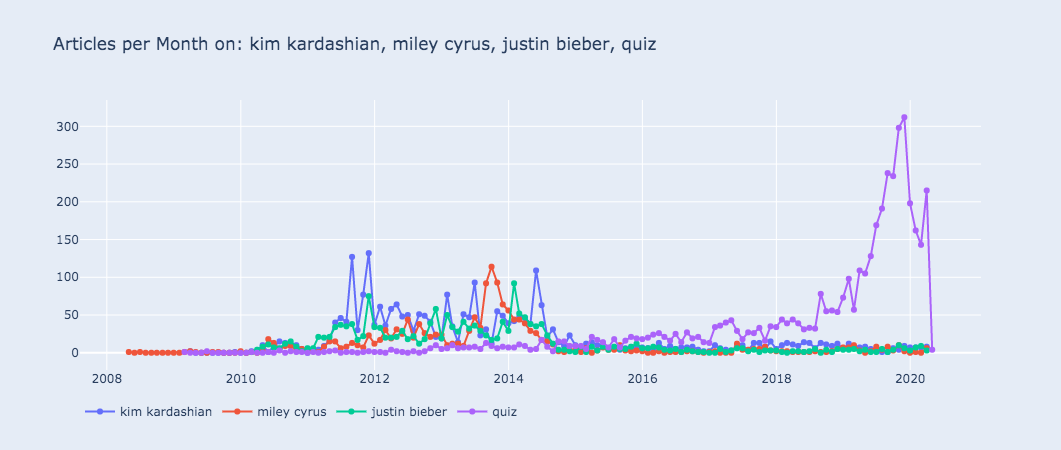

In [52]:
compare_topics('kim kardashian', 'miley cyrus', 'justin bieber', 'quiz')

This shows that probably the content HuffingtonPost and the others were publishing was celebrity heavy. It also shows how popular quizzes have been, and the massive focus they are giving to them. This raises the question of what those quizzes are about.  
We can count the words in the slugs of a subset of the URLs that contain "quiz" in them. This way we can tell what topics they are using for their quizzes. 

In [53]:
(adv.word_frequency(slugs[slugs.str.contains('quiz')])
 .iloc[:15, :2].style.format(dict(abs_freq='{:,}')))

,word,abs_freq
0,quiz,"4,121"
1,trivia,275
2,food,200
3,personality,185
4,character,176
5,reveal,166
6,disney,138
7,movie,131
8,quizzes,120
9,youll,113


## Summary

We now have a good overview on the size and structure of the dataset. We spotted a few issues in the data. To better structure it, we created a few columns so we can more easily aggregate by language, category, author, date, and finally the titles of articles.  
Obviously you don't get the full view on the website by the sitemaps alone, but they provide a very fast way to get a lot of information on publishing activity and content as seen above. 
The way we dealt with "lastmod" is pretty standard (many sites also provide the time of publishing and not just the date), but the URLs are different for every site. 

After this preparation and getting familiar with some of the possible pitfalls you may face, you can now start a proper analysis of the content. Some ideas you might want to explore: topic modelling, word co-occurrence,  entity extraction, document clustering, and doing these for different time ranges and for any of the other available parameters we created. 